# Final assignment Data Learning 2

I want to invest a 1000 euros in a company trading at Nasdaq either Apple, Alphabet(parent company of Google), Microsoft or Tesla. There are 4 companies that managed to overcome the difficulties encountered in the beggining of the pandemic. I want to make a predictive model for the 4 companies to help me decide where I should invest. For starting, this notebook is divided by the 4 companies stock's name (AAPL, GOOG, MSFT and TSLA). First you will find the part where data was retrieved thanks to Yahoo Finance Data Downloader, which allows users to collect data of stock prices and of financial historical data. Following this, you will find the functions created make the assignment. I chose linear regression because it allows to analyze two seperate variables and tries to define a relationship, namely time and price; while the tree regressor is used for  predicting continuous output variables.  


In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import datetime as dt
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import math
from sklearn.metrics import r2_score
import snscrape.modules.twitter as sntwitter
from textblob import TextBlob
plt.style.use('seaborn-pastel')


For each company, data will be retrieved on the same period: January first 2020 to December 31 2020. I had to reduce the size of the financial data because it took days to get tweets from only two companies and thought it was a bit of a waste of time.

In [2]:
apple_data = yf.download("AAPL", start="2020-01-01", end="2020-12-31")
apple_data.shape#just to check it worked well and that sets are the same length

[*********************100%***********************]  1 of 1 completed


(253, 6)

In [3]:
alphabet_data = yf.download("GOOG", start="2020-01-01", end="2020-12-31")
alphabet_data.shape

[*********************100%***********************]  1 of 1 completed


(253, 6)

In [4]:
microsoft_data = yf.download("MSFT", "2020-01-01", end="2020-12-31")
microsoft_data.shape

[*********************100%***********************]  1 of 1 completed


(253, 6)

In [5]:
tesla_data = yf.download("TSLA", start="2020-01-01", end="2020-12-31")
tesla_data.shape

[*********************100%***********************]  1 of 1 completed


(253, 6)

Then, 4 seperate csv files are created for each company.

In [6]:
alphabet_data.to_csv("Alphabet_data.csv")
microsoft_data.to_csv('Microsoft_data.csv')
apple_data.to_csv('Apple_data.csv')
tesla_data.to_csv('Tesla_data.csv')

# Functions

## Function for downloading tweets for each company over a year

For downloading the tweets I used Twitter sns scraper. 

In [7]:
def download_tweets(query, filename):
    print('Downloading :', query)
    #tool to retrieves all items from sns scraper
    generator = sntwitter.TwitterSearchScraper(query).get_items()
    #creates an empty list to append downloaded tweets
    tweets_as_dicts = []
    #defining columns and content to be put in them
    for tweet in generator:
        # print(tweet.date)
        tweets_as_dicts.append({'date': tweet.date,
                                'id': tweet.id,
                                'content': tweet.content,
                                'username': tweet.username})
    #creates a dataframe   
    df = pd.DataFrame(tweets_as_dicts)
    #saves the file in a csv
    df.to_csv(filename)
    print('Saved tweets into ', filename)

## Merging tweets and financial data sets

Merges both finanial and tweet datasets.

In [8]:
def merge_datasets(tweets, financial_data):
    #creates the column sentiment and uses NLP to get the sentiment 
    tweets['Sentiment'] = tweets['content'].apply(lambda tweet: TextBlob(tweet).sentiment.polarity)
    #formats the date tweets data's column from string to date-time 
    tweets["date"] = pd.to_datetime(tweets["date"])
    #formats the data financial data's column from string to date time
    financial_data["Date"] = pd.to_datetime(financial_data["Date"]).dt.tz_localize('UTC')
    #setting the index on Date for merging
    financial_data = financial_data.set_index('Date')
    #resamples the tweet DF and gets the mean sentiment per day and drops NaNs
    tweets_resampled = tweets.resample('D', on='date').mean().dropna()
    #drops unnecessary columns
    sentiment_df = tweets_resampled.drop(['Unnamed: 0', 'id'], axis=1)
    #renames the column date to Date for merging both datasets
    sentiment_df = sentiment_df.rename(columns={"date": "Date"})
    #merging the two datasets 
    merged = pd.merge(financial_data, sentiment_df, how='left', left_index=True, right_index=True)
    merged['day of week'] = merged.index.dayofweek
    merged['day of month'] = merged.index.day.values
    merged['Sentiment'] = merged['Sentiment'].fillna(0)
    merged['date numeric'] = pd.to_numeric(pd.to_datetime(merged.index)) 
    return merged


## Function to plot the "Close" column 

Plotting the close price column.

In [9]:
def show_stock_price(data):
    #setting the style
    plt.style.use('seaborn-pastel')
    #setting the size
    plt.figure(figsize= (20,5))
    #setting the title of the plot
    plt.title('Close')
    #setting the x axis label
    plt.xlabel('Days')
    #setting the x axis label
    plt.ylabel('Close Price USD')
    #loading the data 
    plt.plot(data['Close'])
    #showing the plot
    plt.show()


## Tree regressor function

Creation of the first model 

In [10]:
def run_tree_regressor(data, columns):
    #Setting the x variable
    x = np.array(data[columns])
    #Setting the y variable and reshapes its size to match x length
    y = np.array(data['Close']).reshape(-1, 1)
    #splitting the data
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.30)
    #Creating the tree
    tree_regressor = DecisionTreeRegressor().fit(x_train, y_train)
    #Generates prediction for the test set
    predicted = tree_regressor.predict(x_test)
    # assigning y_test
    expected = y_test
    #getting the mean squared error for y_test and predicted 
    mse = mean_squared_error(y_test, predicted)
    #getting the R2 score of y_test and predicted
    score = r2_score(y_test, predicted)
    #setting the size 
    plt.figure(figsize=(4, 3))
    plt.scatter(expected, predicted)
    #setting the size 
    plt.plot([0, 50], [0, 50], '--k')
    #setting the title 
    plt.title(f'MSE : {mse}  | r2 score : {score}')
    #resizes the subplot
    plt.axis('tight')
    #setting labels
    plt.xlabel('Expected')
    plt.ylabel('Predicted')
    #fitting the line
    plt.tight_layout()
    #showing the plot
    plt.show()

## Linear regression function

Second model

In [11]:
def run_linear_regression(data, columns):
    #Settting the x variable
    x = np.array(data[columns])
    #Setting the y variable and reshapes its size to match x length
    y = np.array(data['Close']).reshape(-1, 1)
    #Splitting the data
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30)
    #Creating the linear regression
    linear_regression = LinearRegression().fit(x_train, y_train)
    #Generates prediction for the test set
    predicted = linear_regression.predict(x_test)
    #getting the mean squared error for y_test and predicte
    mse = mean_squared_error(y_test, predicted)
    #getting the R2 score of y_test and predicted
    score = r2_score(y_test, predicted)
    expected = y_test
    plt.figure(figsize=(4, 3))
    #plotting expected and predicted values
    plt.scatter(expected, predicted)
    #setting the size 
    plt.plot([0, 50], [0, 50], '--k')
    #setting the title 
    plt.title(f'MSE : {mse}  | r2 score : {score}')
    #resizes the subplot
    plt.axis('tight')
    #setting labels
    plt.xlabel('Expected')
    plt.ylabel('Predicted')
    #fitting the line
    plt.tight_layout()
    #showing the plot
    plt.show()

## Correlation matrix function

Correlation function

In [12]:
def correlation_between_variables(data):
    #setting the size of the matrix
    corr_viz = plt.figure(figsize=(10, 5))
    #plotting the data 
    plt.matshow(data.corr(), fignum= corr_viz.number)
    #setting the tick with the names of the companies
    tick_marks = range(len(data.columns))
    #plotting ticks, data, size and rotation for the ticks
    plt.xticks(tick_marks, data.columns, fontsize=12, rotation=45)
    #plotting ticks, data and size 
    plt.yticks(tick_marks, data.columns, fontsize=12)
    #adding the colorbar
    color_bar = plt.colorbar()
    #setting the size of the bar
    color_bar.ax.tick_params(labelsize=14)
    #adding the title of the plot
    plt.title('Correlation Matrix of Close', fontsize=16)
    #showing the plot
    plt.show()
    

# Apple


## Visualizing the 'Close' price column of Apple

For each company, the data of the stock price will be vizualised with a plot. The 'Close' column represents the price the stock was on each day when the market closed in the United States of America.

In [13]:
#loading the necessary files
download_tweets(query='Apple stock AAPL since:2020-01-01 until:2020-12-31',
                filename='AAPL_20202.csv')
apple_tweets = pd.read_csv('AAPL_20202.csv')
apple_financial = pd.read_csv('Apple_data.csv')
#calling the function to merge tweets and data from Yahoo
apple_data = merge_datasets(apple_tweets, apple_financial)

<ipython-input-7-ddd3b372db19>:13: FutureWarning: username is deprecated, use user.username instead
  'username': tweet.username})


Saved tweets into  AAPL_20202.csv


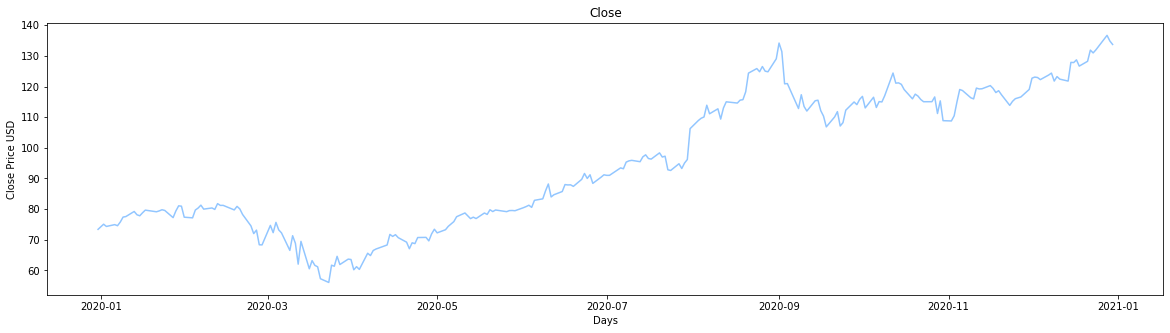

In [14]:
show_stock_price(apple_data)

## Visualizing Apple's data to chose variables to fit in the model

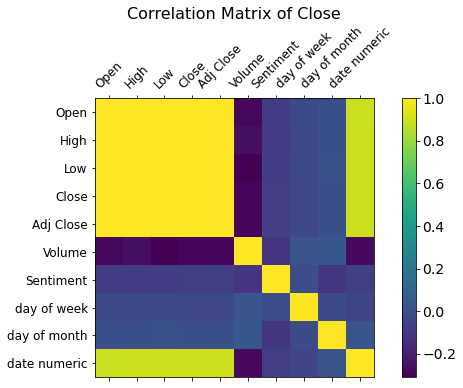

In [15]:
correlation_between_variables(apple_data)

The correlation is very high high between 5 variables in yellow. I will use them in the model to see how good or bad models are performing with those variables. Correlation with tweets' sentiment and all columns from the original Yahoo file is slightly negative. As the 'Close' column is the most interesting for the assignment and the prediction I will use 'Close' column in pair with another column ('High', 'Low', 'Open' 'Volume' and 'Sentiment for y variables and finish with only 'Close' alone as y.


## Creating the models for Apple

## Visualization of Linear Regression and (Apple) Tree

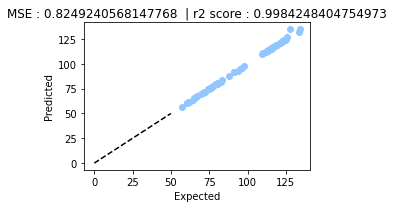

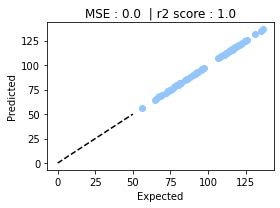

In [16]:
run_tree_regressor(apple_data, ['Close', 'Sentiment'])
run_linear_regression(apple_data, ['Close', 'Sentiment'])

Tree regressor: the RMSE is 0.55, which means the model is about 0.55 dollars off. The R^2 is 0.99 which means 99% of the variation is explained by the model.    
Linear regression: the RMSE is -2.53 and the R^2 is 100 which means 100 of the variation should be explained by the model.

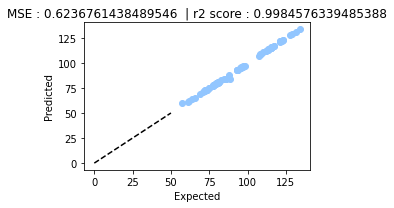

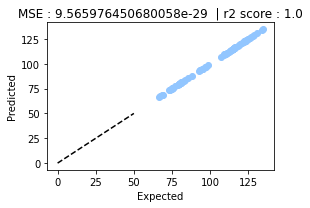

In [17]:
run_tree_regressor(apple_data, ['Close', 'Open'])
run_linear_regression(apple_data, ['Close', 'Open'])

Tree regressor: the RMSE is 0.45, which means the model is about 0.45 dollars off. The R^2 is 0.99 which means 99% of the variation is explained by the model.    
Linear regression: the RMSE is -0.05 and the R^2 is 100% which means 100 of the variation should be explained by the model.

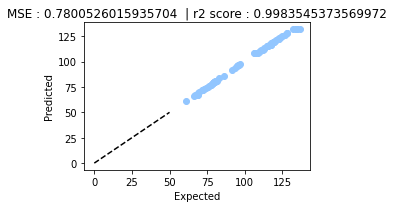

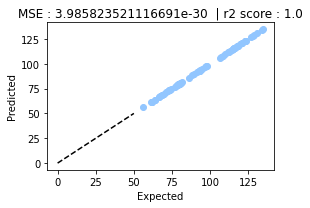

In [18]:
run_tree_regressor(apple_data, ['Close', 'High'])
run_linear_regression(apple_data, ['Close', 'High'])

Tree regressor: the RMSE is 0.15, which means the model is about 0.15 dollars off. The R^2 is 0.99 which means 99% of the variation is explained by the model.    
Linear regression: the RMSE is -0.05 and the R^2 is 100% which means 100 of the variation should be explained by the model.

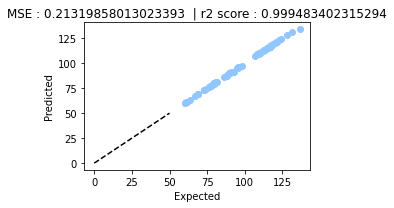

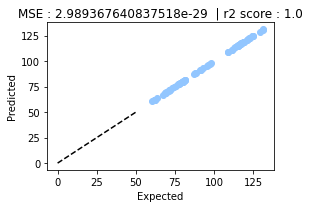

In [19]:
run_tree_regressor(apple_data, ['Close', 'Low'])
run_linear_regression(apple_data, ['Close', 'Low'])

Tree regressor: the RMSE is 0.35, which means the model is about 0.35 dollars off. The R^2 is 0.99 which means 99% of the variation is explained by the model which is good.    
Linear regression: the RMSE is -1.1 and the R^2 is 100% which means 100 of the variation should be explained by the model.

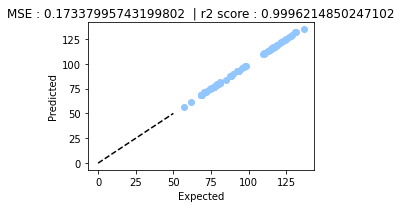

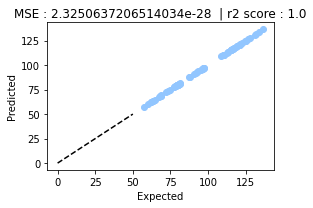

In [20]:
run_tree_regressor(apple_data, ['Close', 'Adj Close'])
run_linear_regression(apple_data, ['Close', 'Adj Close'])

Tree regressor: the RMSE is 0.45, which means the model is about 0.45 dollars off. The R^2 is 0.99 which means 99% of the variation is explained by the model which is good.    
Linear regression: the RMSE is -0.05 off and the R^2 is 100% which means 100 of the variation should be explained by the model.

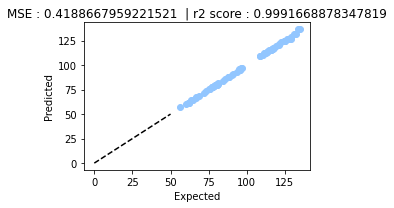

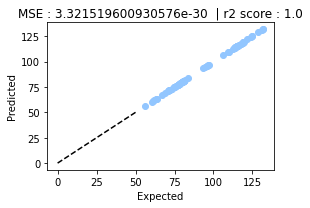

In [21]:
run_tree_regressor(apple_data, ['Close', 'Volume'])
run_linear_regression(apple_data, ['Close', 'Volume'])

Tree regressor: the RMSE is 0.14, which means the model is about 0.14 dollars off. The R^2 is 0.99 which means 99% of the variation is explained by the model which is good.    
Linear regression: the RMSE is -6.64 off and the R^2 is 100% which means 100 of the variation should be explained by the model.

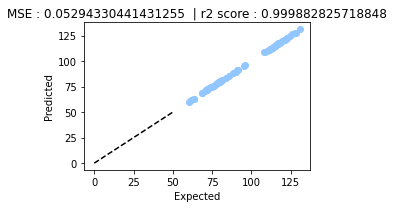

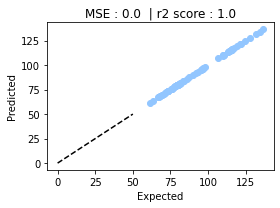

In [22]:
run_tree_regressor(apple_data, ['Close'])
run_linear_regression(apple_data, ['Close'])


Tree regressor: the RMSE is 0.38, which means the model is about 0.38 dollars off. The R^2 is 0.99 which means 99% of the variation is explained by the model which is good.    
Linear regression: the RMSE is -6.11 off and the R^2 is 100% which means 100 of the variation should be explained by the model.

## Performance of Apple's models

The models seem to work best with Apple data. They do not massively overshoot nor undershoot.
    

# Alphabet 

In [23]:
#loading the necessary files
download_tweets(query='Alphabet stock GOOG since:2020-01-01 until:2020-12-31',
                filename='GOOG_20202.csv')
alphabet_tweets = pd.read_csv('GOOG_20202.csv')
alphabet_financial = pd.read_csv('Alphabet_data.csv')
#calling the function to merge tweets and data from Yahoo
alphabet_data = merge_datasets(alphabet_tweets, alphabet_financial)

<ipython-input-7-ddd3b372db19>:13: FutureWarning: username is deprecated, use user.username instead
  'username': tweet.username})


Saved tweets into  GOOG_20202.csv


## Visualizing the 'Close' price column of Alphabet

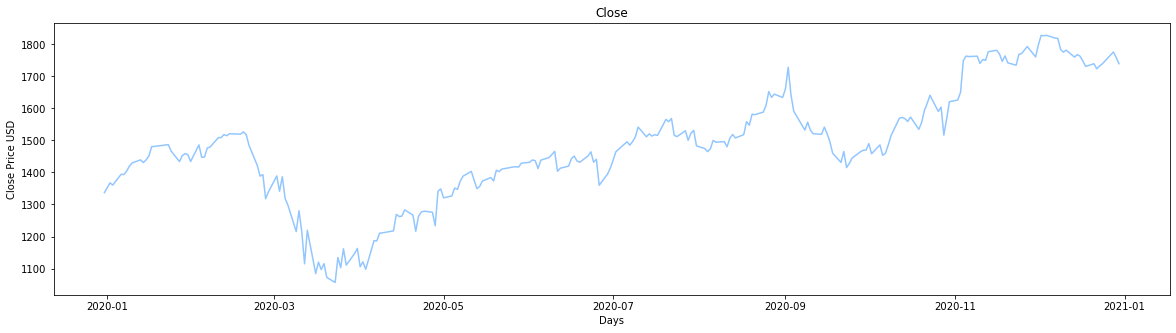

In [24]:
show_stock_price(alphabet_data)



## Vizualising Alphabet's data to chose variables to fit in the model

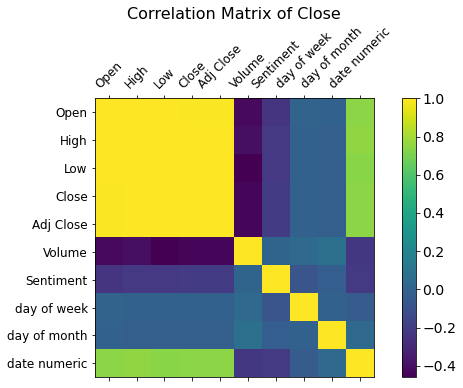

In [25]:
correlation_between_variables(alphabet_data)

The correlation is very high high between the 5 variables in yellow. It is interesting to see that correaltion is higher with the days of week and day of month columns compared to Apple's data. Correlation with tweets' sentiment and all columns from the original Yahoo file is slightly negative.

## Visualization of Linear Regression and Tree

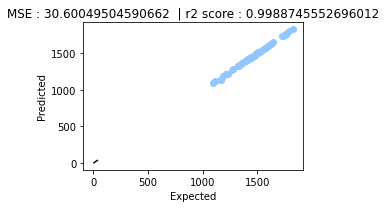

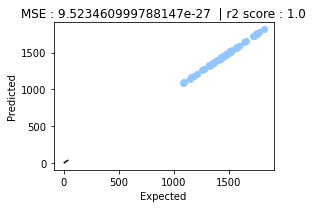

In [26]:
run_tree_regressor(alphabet_data, ['Close', 'Sentiment'])
run_linear_regression(alphabet_data, ['Close', 'Sentiment'])


Tree regressor: the RMSE is 11,95 which means the model is about 11,95 dollars off. The R^2 is 0.99 which means 99% of the variation is explained by the model which is good.    
Linear regression: the RMSE is -1.05 and the R^2 is 100% which means 100 of the variation should be explained by the model.

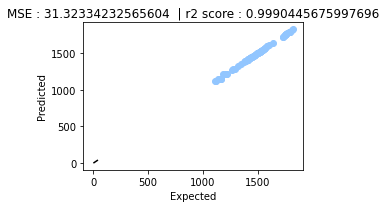

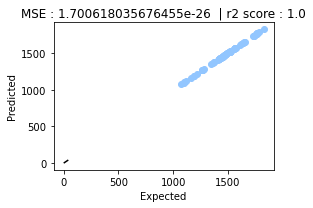

In [27]:
run_tree_regressor(alphabet_data, ['Close', 'Open'])
run_linear_regression(alphabet_data, ['Close', 'Open'])

Tree regressor: the RMSE is 191,99 which means the model is about 0 dollars off. The R^2 is 0.99 which means 99% of the variation is explained by the model which is good.    
Linear regression: the RMSE is -3.46 and undershoots a little and the R^2 is 100% which means 100 of the variation should be explained by the model.

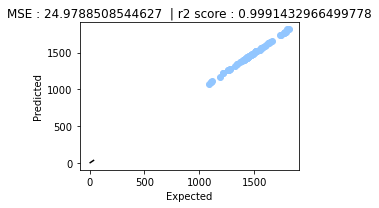

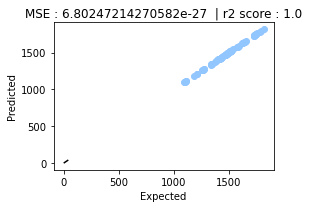

In [28]:
run_tree_regressor(alphabet_data, ['Close', 'High'])
run_linear_regression(alphabet_data, ['Close', 'High'])

Tree regressor: the RMSE is 15.58 , which means the model is about 16 dollars off. The R^2 is 0.99 which means 99% of the variation is explained by the model which is good.    
Linear regression: the RMSE is -1.56 and undershoots a little and the R^2 is 100% which means 100 of the variation should be explained by the model.

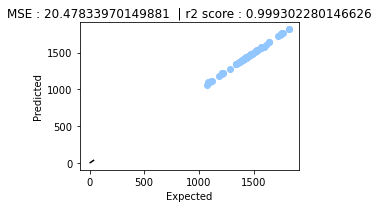

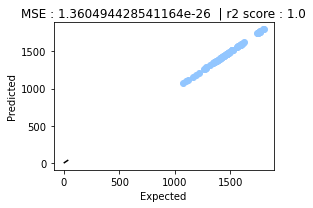

In [29]:
run_tree_regressor(alphabet_data, ['Close', 'Low'])
run_linear_regression(alphabet_data, ['Close', 'Low'])

Tree regressor: the RMSE is 82.26, which means the model is about 82,26 dollars off. The R^2 is 0.99 which means 99% of the variation is explained by the model which is good.    
Linear regression: the RMSE is -1.36 and the R^2 is 100% which means 100 of the variation should be explained by the model.

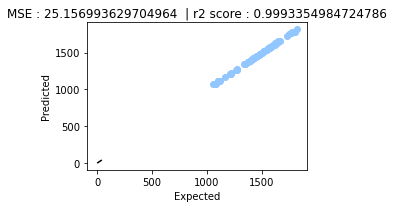

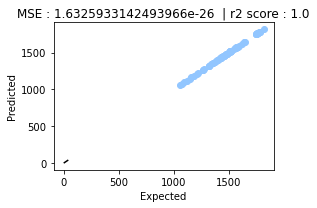

In [30]:
run_tree_regressor(alphabet_data, ['Close', 'Adj Close'])
run_linear_regression(alphabet_data, ['Close', 'Adj Close'])

Tree regressor: the RMSE is 21.06, which means the model is about 21 dollars off. The R^2 is 0.99 which means 99% of the variation is explained by the model which is good.    
Linear regression: the RMSE is -4.8 and the R^2 is 100% which means 100 of the variation should be explained by the model.

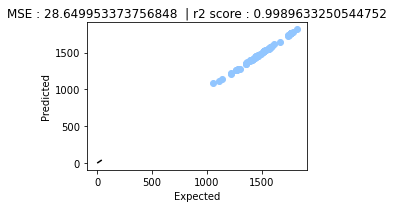

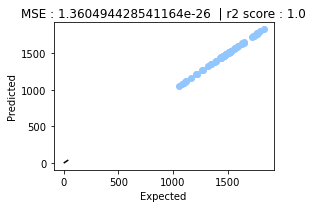

In [31]:
run_tree_regressor(alphabet_data, ['Close', 'Volume'])
run_linear_regression(alphabet_data, ['Close', 'Volume'])

Tree regressor: the RMSE is 35.215, which means the model is about 35 dollars off. The R^2 is 0.99 which means 99% of the variation is explained by the model which is good.    
Linear regression: the RMSE is -5.44 and the R^2 is 100% which means 100 of the variation should be explained by the model.

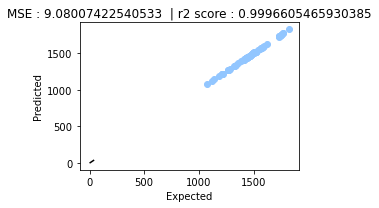

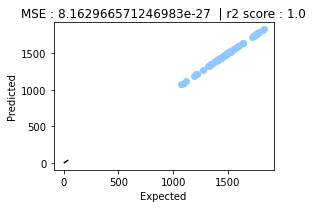

In [32]:
run_tree_regressor(alphabet_data, ['Close'])
run_linear_regression(alphabet_data, ['Close'])

Tree regressor: the RMSE is 14.33, which means the model is about 14 dollars off. The R^2 is 0.99 which means 99% of the variation is explained by the model which is good.    
Linear regression: the RMSE is -0.05 and the R^2 is 100% which means 100 of the variation should be explained by the model.

## Performance of Alphabet's models

With this data set from Alphabet the models are not working properly, especially compared with Apple. The tree regressor overshoots and the linear regression is not doing well either.

# Microsoft

In [33]:
download_tweets(query='Microsoft stock MSFT since:2020-01-01 until:2020-12-31',
                filename='MSFT_20202.csv')

<ipython-input-7-ddd3b372db19>:13: FutureWarning: username is deprecated, use user.username instead
  'username': tweet.username})


Saved tweets into  MSFT_20202.csv


In [34]:
#loading the necessary files
download_tweets(query='Microsoft stock MSFT since:2020-01-01 until:2020-12-31',
                filename='MSFT_20202.csv')
msft_tweets = pd.read_csv('MSFT_20202.csv')
msft_financial = pd.read_csv('Microsoft_data.csv')
#calling the function to merge tweets and data from Yahoo
msft_data = merge_datasets(msft_tweets, msft_financial)


<ipython-input-7-ddd3b372db19>:13: FutureWarning: username is deprecated, use user.username instead
  'username': tweet.username})


Saved tweets into  MSFT_20202.csv


## Visualizing the 'Close' price column of Microsoft

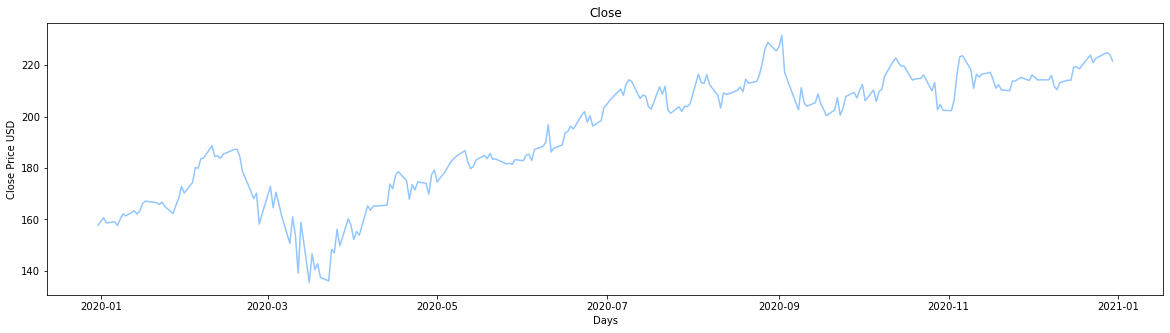

In [35]:
#calling the function to display the plot for the "Close" column
show_stock_price(msft_data)

## Vizualising Microsoft's data to chose variables to fit in the model

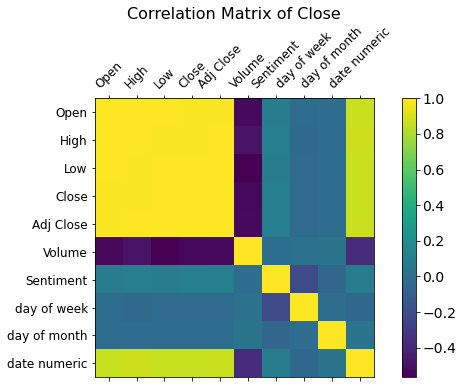

In [36]:
correlation_between_variables(msft_data)

The correlation is very high between the 5 variables in yellow. It is interesting to see that correaltion is higher with the days of week and day of month columns compared to Apple's data. Correlation with tweets' sentiment and all columns from the original Yahoo file is slightly negative.

## Visualization of Linear Regression and Tree Regressor for Microsoft

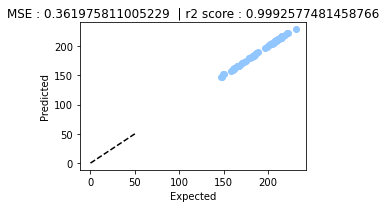

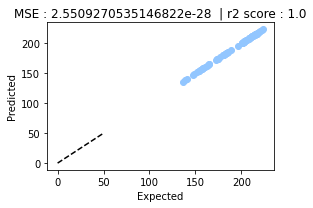

In [37]:
run_tree_regressor(msft_data, ['Close', 'Sentiment'])
run_linear_regression(msft_data, ['Close', 'Sentiment'])


Tree regressor: the RMSE is 0.55, which means the model is about 0.55 dollars off. The R^2 is 0.99 which means 99% of the variation is explained by the model which is good.    
Linear regression: the RMSE is -0.05 and the R^2 is 100% which means 100 of the variation should be explained by the model.

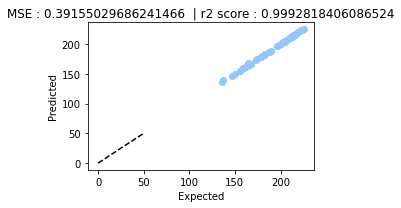

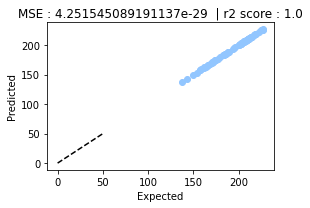

In [38]:
run_tree_regressor(msft_data, ['Close', 'Open'])
run_linear_regression(msft_data, ['Close', 'Open'])


Tree regressor: the RMSE is 1.15, which means the model is about 1 dollars off. The R^2 is 0.99 which means 99% of the variation is explained by the model which is good.    
Linear regression: the RMSE is -4.2515 and the R^2 is 100% which means 100 of the variation should be explained by the model.

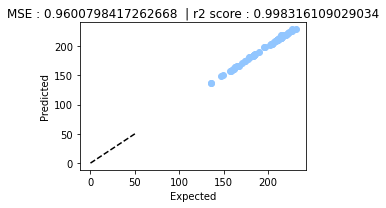

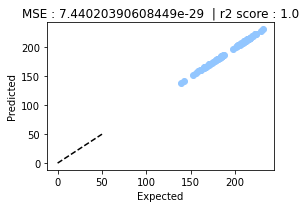

In [39]:
run_tree_regressor(msft_data, ['Close', 'High'])
run_linear_regression(msft_data, ['Close', 'High'])

Tree regressor: the RMSE is 0.81, which means the model is about 0.81 dollars off. The R^2 is 0.99 which means 99% of the variation is explained by the model which is good.    
Linear regression: the RMSE is -5.63 and the R^2 is 100% which means 100 of the variation should be explained by the model.

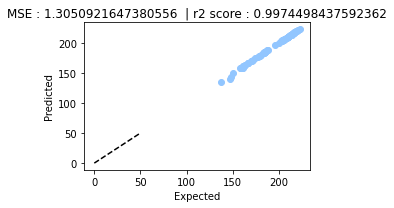

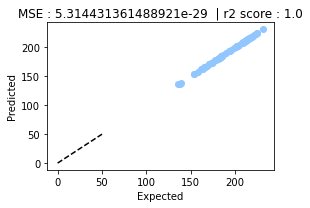

In [40]:
run_tree_regressor(msft_data, ['Close', 'Low'])
run_linear_regression(msft_data, ['Close', 'Low'])

Tree regressor: the RMSE is 1.08, which means the model is about 1 dollar off. The R^2 is 0.99 which means 99% of the variation is explained by the model which is good.    
Linear regression: the RMSE is -1.16 and the R^2 is 100% which means 100 of the variation should be explained by the model.

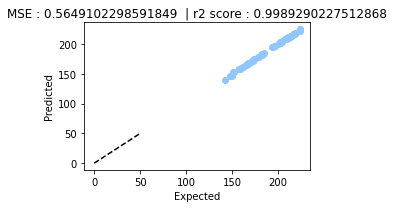

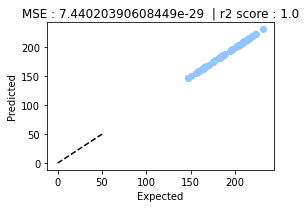

In [41]:
run_tree_regressor(msft_data, ['Close', 'Adj Close'])
run_linear_regression(msft_data, ['Close', 'Adj Close'])

Tree regressor: the RMSE is 0.26, which means the model is about 0.26 dollar off. The R^2 is 0.99 which means 99% of the variation is explained by the model which is good.    
Linear regression: the RMSE is -0.05 and the R^2 is 100% which means 100 of the variation should be explained by the model.

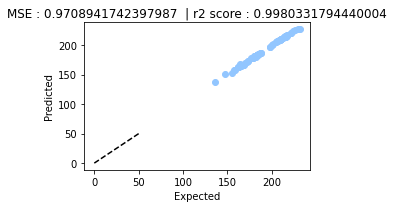

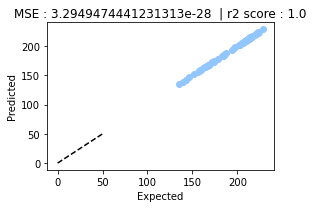

In [42]:
run_tree_regressor(msft_data, ['Close', 'Volume'])
run_linear_regression(msft_data, ['Close', 'Volume'])

Tree regressor: the RMSE is 0.85, which means the model is about 0.85 dollars off. The R^2 is 0.99 which means 99% of the variation is explained by the model which is good.    
Linear regression: the RMSE is -3.6 and the R^2 is 100% which means 100 of the variation should be explained by the model.

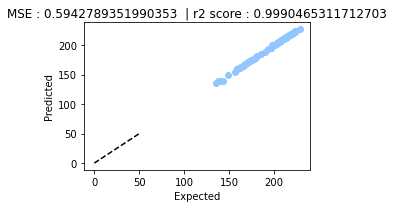

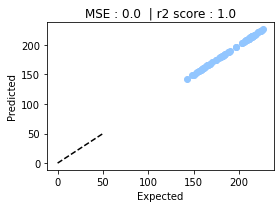

In [43]:
run_tree_regressor(msft_data, ['Close'])
run_linear_regression(msft_data, ['Close'])

Tree regressor: the RMSE is 0.14, which means the model is about 0.14 dollar off. The R^2 is 0.99 which means 99% of the variation is explained by the model which is good.    
Linear regression: the RMSE is -3.5 and the R^2 is 100% which means 100 of the variation should be explained by the model.

## Perfomance of Miscrosoft's models

Models are not working well both the tree regressor and linear regression. It is even more obvious when we look at the representation of the models and their performance.

# Tesla

In [44]:
#loading the necessary files
download_tweets(query='Tesla stock TSLA since:2020-01-01 until:2020-12-31',
                filename='TSLA_20202.csv')
tesla_tweets = pd.read_csv('TSLA_20202.csv')
tesla_financial = pd.read_csv('Tesla_data.csv')
#loading the necessary files
tesla_data = merge_datasets(tesla_tweets, tesla_financial)




<ipython-input-7-ddd3b372db19>:13: FutureWarning: username is deprecated, use user.username instead
  'username': tweet.username})


Saved tweets into  TSLA_20202.csv


## Vizualising the 'Close' price column of Tesla

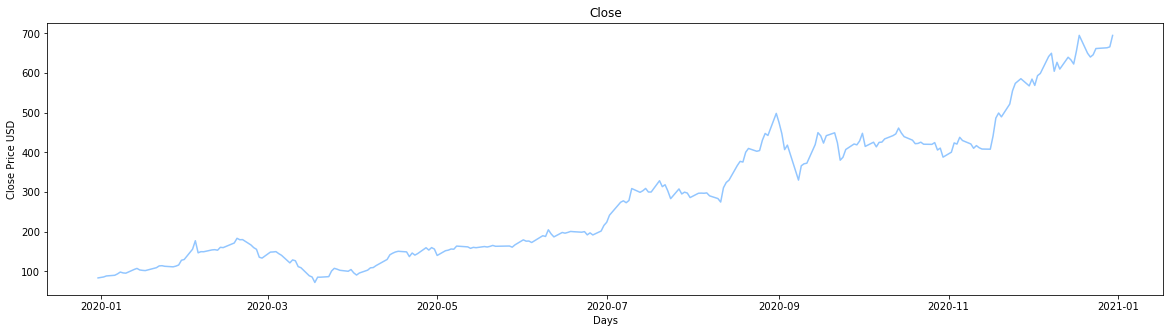

In [45]:
show_stock_price(tesla_data)

## Vizualising Tesla's data's correlation to chose variables to fit in the model

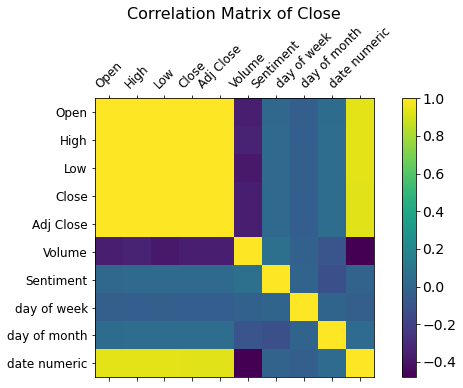

In [46]:
correlation_between_variables(tesla_data)

The correlation is very high between 5 variables in yellow. I will use them in the model to see how good or bad models are performing with those variables. It is interesting to see that correaltion is higher also here with the days of week and day of month columns compared to Apple's data. Correlation with tweets' sentiment and all columns from the original Yahoo file is slightly negative.

##  Visualization of Linear Regression and Tree Regressor for Tesla

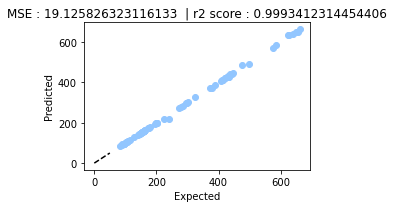

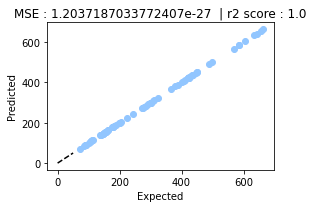

In [47]:
run_tree_regressor(tesla_data, ['Close', 'Sentiment'])
run_linear_regression(tesla_data, ['Close', 'Sentiment'])

Tree regressor: the RMSE is 21.44, which means the model is about 21 dollars off. The R^2 is 0.99 which means 99% of the variation is explained by the model which is good.    
Linear regression: the RMSE is -2.27 and the R^2 is 100% which means 100 of the variation should be explained by the model.

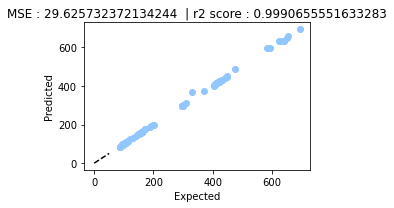

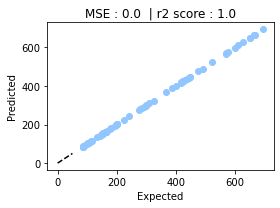

In [48]:
run_tree_regressor(tesla_data, ['Close', 'Open'])
run_linear_regression(tesla_data, ['Close', 'Open'])

Tree regressor: the RMSE is 36.70, which means the model is about 36.70 dollars off. The R^2 is 0.99 which means 99% of the variation is explained by the model which is good.    
Linear regression: the RMSE is -1.68 and the R^2 is 100% which means 100 of the variation should be explained by the model.

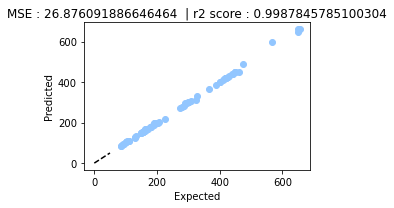

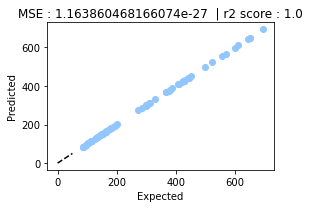

In [49]:
run_tree_regressor(tesla_data, ['Close', 'High'])
run_linear_regression(tesla_data, ['Close', 'High'])

Tree regressor: the RMSE is 32.96, which means the model is about 0.99 dollars off. The R^2 is 0.99 which means 99% of the variation is explained by the model which is good.    
Linear regression: the RMSE is -1.67 and the R^2 is 100% which means 100 of the variation should be explained by the model.

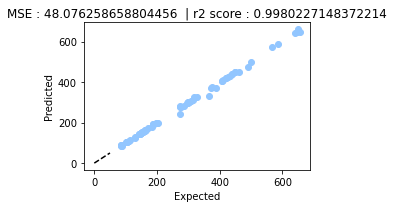

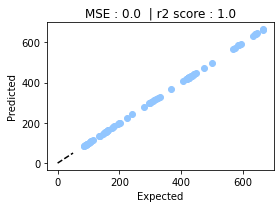

In [50]:
run_tree_regressor(tesla_data, ['Close', 'Low'])
run_linear_regression(tesla_data, ['Close', 'Low'])

Tree regressor: the RMSE is 26.22, which means the model is about 26.22 dollars off. The R^2 is 0.99 which means 99% of the variation is explained by the model which is good.    
Linear regression: the RMSE is -1.41 and the R^2 is 100% which means 100 of the variation should be explained by the model.

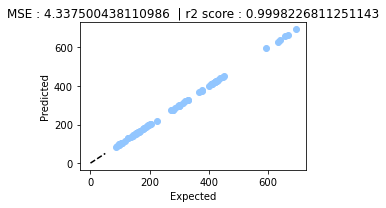

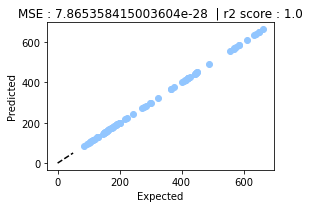

In [51]:
run_tree_regressor(tesla_data, ['Close', 'Adj Close'])
run_linear_regression(tesla_data, ['Close', 'Adj Close'])

Tree regressor: the RMSE is 12.71, which means the model is about 12.71 dollars off. The R^2 is 0.99 which means 99% of the variation is explained by the model which is good.    
Linear regression: the RMSE is -0.05 and the R^2 is 100% which means 100 of the variation should be explained by the model.

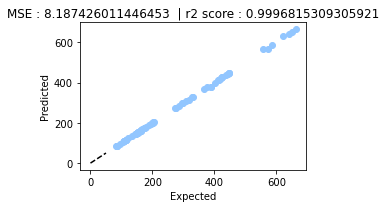

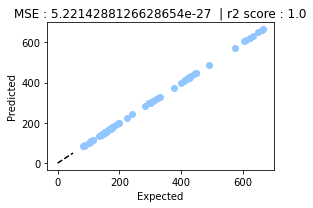

In [52]:
run_tree_regressor(tesla_data, ['Close', 'Volume'])
run_linear_regression(tesla_data, ['Close', 'Volume'])

Tree regressor: the RMSE is 14.42, which means the model is about 14.42 dollars off. The R^2 is 0.99 which means 99% of the variation is explained by the model which is good.    
Linear regression: the RMSE is -3.21 and the R^2 is 100% which means 100 of the variation should be explained by the model.

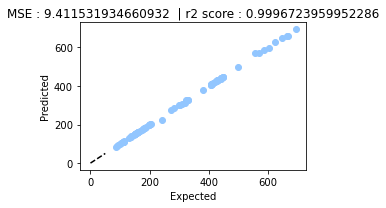

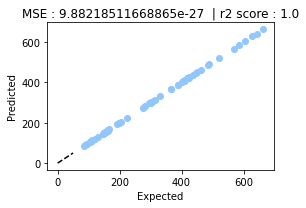

In [53]:
run_tree_regressor(tesla_data, ['Close'])
run_linear_regression(tesla_data, ['Close'])

Tree regressor: the RMSE is 17.81, which means the model is about 17.81 dollars off. The R^2 is 0.99 which means 99% of the variation is explained by the model which is good.    
Linear regression: the RMSE is -5.23 and the R^2 is 100% which means 100 of the variation should be explained by the model.

## Performance of Tesla's models

Models for Tesla are not working properly either. The tree regressor overshoots while the regression undershoots a little. I would not trust these models to make my decision.

# Conclusion

Overall I do not think the models work well for predicting stock prices. Nonetheless, it seems that models worked best with Apple's data: it that had overall a better RMSE score and R^2 score which helps seeing the models as more realiable. I would then invest my 1000 euros in Apple. I think that with a larger data set I could have seen more things and models would have been a little bit better at predicting prices.